# Aircraft Engine Classifiation Demonstration
### Using AWS Sagemaker Machine Learning Service
## Background
The purpose of this report is to demonstrate the use of the Amazon Web Service Machine Learning for Classification. The data set we chose is from the Nasa Prognostics Data Library. This library is a collection of time series data sets for making predictions. Many of them are predicting the failure of parts. There are sets for bearings, IGBTs, Trebuchet trajectories and more. For this report I used the Turbofan Engine Degredation data set, it's designed for regression experiments so I thought it would have some interesting challeneges for classification.

https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

These data sets are used for an important area of machine learning, predictive maintenance. Given measurements of machines as they deteriorate from a good state to a failure can you train a model to detect the impending failure of a different part.

This report will demonstrate how to do classification using two diffrent algorithms in Amazon Web Services (AWS) Sagemaker.  Sagemaker is the AWS Machine Learning Service with tools to train and deploy machine learning models.  Additional details o the service can be found: https://aws.amazon.com/sagemaker/.  

## Data
The initial step of any classification process is to get the data.  Then some basic exploration of the properties of the data can help to clean it and format it for the classification model being used.  The two algorithms being used in this report have different data requirements which makes the preprocessing slightly different.

### Import Dependancies
This analysis is being done in Python.  I separated the dependancies into two parts.  The first is the standard Python imports.  The second section has the specific resources required by Sagemaker, and sets up the AWS environment.

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import io
import os
import time

In [2]:
#AWS Setup
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sklearn.datasets import dump_svmlight_file   
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()
prefix = 'sagemaker/engines'
role = sagemaker.get_execution_role()

s3 = boto3.resource('s3', region_name=region)
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-east-1-609826415497


### Import Data
Providing the link to raw data, or that data itself as a file helps to improve reproducability of your report. It can be a tutorial for someone to follow the examples themselves or groundbreaking research that allows others to replicate your research, making the data available improves the value of the report.  This report provides a link to download the file in code and cites the data at the end of this bloc. The following block which downloads and extracts the code does not need to be run every time.  You may wish to comment it out after the first time to make the document run faster.  
The next cell loads the data from the computer and loads it into a data frame. Included in the zip file is a readme.txt file.  The readme explains the contents of the zip.  In summary there are 4 experiments, each of which consists of 3 files.  The training data, the test data, and the RUL (Remaining Useful Life) for the test data.  The test and training data are formatted the same with one excepion. For the training data the last cycle is the one on which it fails.  For the test data the last provided cycle is not a failure, and the the RUL is needed to calculate that.


ID: Number identifying a unique engine.  Results are sorted by ID.
CYCLE: Starts at 1 and increases with each row.
Settings(3): Three different settings for the engine.
Sensors(21): Twenty one different measurements for each flight.


<sub>A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA<sub>

In [4]:
#Download and extract the raw data
#constants definition
url ='https://ti.arc.nasa.gov/c/6/'
zippedfile = 'CMAPSSData.zip'

r = requests.get(url)
open(zippedfile,'wb').write(r.content)
zipfile.ZipFile(zippedfile, 'r').extractall()

In [3]:
train_header = ["id", "cycle", "set1", "set2", "set3", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9",
                "s10", "s11", "s12", "s13", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21"]
train_data = pd.read_csv('train_FD001.txt', delim_whitespace=True, header = None, names = train_header )
train_data.shape

(20631, 26)

#### Add remaining cycles
Each engine was run to failure, so the final run is the failure.  We need to label each row with the remaining cycles to failure.  Then we can later create a boolean for fail within 5 cycles, or category for fail( No, Soon, Urgent) or other classification scheme.
            

In [4]:
train_data["remaining"] = train_data.groupby("id").cumcount(ascending=False)
train_data.head()

id  cycle    set1    set2   set3      s1      s2       s3       s4     s5  \
0   1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      s13      s14     s15   s16  s17   s18    s19    s20      s21  \
0  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190   
1  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236   
2  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442   
3  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739   
4  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044   

   remaining  
0        191  
1        190  
2        189  
3        188  
4        187  

[5 rows x 27 columns]

### Load Testing Data
Testing data is the same structure as training data, except the last cycle is not the failure.  For the test set the Remaining Useful Life (RUL) is the number of cycles the engine has until failure, and is stored in a separate file.  We use that to calculate the ground truth RUL we will need to evaluate the effectiveness of the model.


In [5]:
test_data = pd.read_csv('test_FD001.txt', delim_whitespace=True, header = None, names = train_header )
test_data["partial_rul"] = test_data.groupby("id").cumcount(ascending=False)
#Get RUL from file
rul = pd.read_csv("RUL_FD001.txt", header = None)
rul.columns = ['rul'] 
rul["id"] = np.arange(len(rul))+1
#Join the RUL of last cycle to test data.
test_data = test_data.merge(rul, how = 'left', on = 'id')
#combine the final cycle RUL with the cycle counts to get the remaining cycles for each row
test_data['remaining'] = test_data['partial_rul'] + test_data['rul']
test_data.head()

id  cycle    set1    set2   set3      s1      s2       s3       s4     s5  \
0   1      1  0.0023  0.0003  100.0  518.67  643.02  1585.29  1398.21  14.62   
1   1      2 -0.0027 -0.0003  100.0  518.67  641.71  1588.45  1395.42  14.62   
2   1      3  0.0003  0.0001  100.0  518.67  642.46  1586.94  1401.34  14.62   
3   1      4  0.0042  0.0000  100.0  518.67  642.44  1584.12  1406.42  14.62   
4   1      5  0.0014  0.0000  100.0  518.67  642.51  1587.19  1401.92  14.62   

   ...     s15   s16  s17   s18    s19    s20      s21  partial_rul  rul  \
0  ...  8.4052  0.03  392  2388  100.0  38.86  23.3735           30  112   
1  ...  8.3803  0.03  393  2388  100.0  39.02  23.3916           29  112   
2  ...  8.4441  0.03  393  2388  100.0  39.08  23.4166           28  112   
3  ...  8.3917  0.03  391  2388  100.0  39.00  23.3737           27  112   
4  ...  8.4031  0.03  390  2388  100.0  38.99  23.4130           26  112   

   remaining  
0        142  
1        141  
2        140  
3        139  
4        138  

[5 rows x 29 columns]

## Exploratory Data Analysis



Exploratory data analysis is the process of understanding the data.  It consists of both numerical checks and visualizations.  This is not a complete list of the exploration that can be done, just an example. A good first step is to check for NAs. This data set does not have any.

In [8]:
train_data.isna().sum().sum()

0

The `describe()` function in Pandas is a useful way to get a feel for the data set at the.  We use it on all the sensor and settings and sensor values.  This has to be done in several steps in order to see all the values

In [9]:
settings = train_data.loc[:, 'set1':'set3']
settings.describe()

set1          set2     set3
count  20631.000000  20631.000000  20631.0
mean      -0.000009      0.000002    100.0
std        0.002187      0.000293      0.0
min       -0.008700     -0.000600    100.0
25%       -0.001500     -0.000200    100.0
50%        0.000000      0.000000    100.0
75%        0.001500      0.000300    100.0
max        0.008700      0.000600    100.0

By inspection  set3, is of no value, all data the same.  

In [10]:
sensors = train_data.loc[:, 's1':'s10']
sensors.describe()

s1            s2            s3            s4            s5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

                 s6            s7            s8            s9           s10  
count  20631.000000  20631.000000  20631.000000  20631.000000  2.063100e+04  
mean      21.609803    553.367711   2388.096652   9065.242941  1.300000e+00  
std        0.001389      0.885092      0.070985     22.082880  4.660829e-13  
min       21.600000    549.850000   2387.900000   9021.730000  1.300000e+00  
25%       21.610000    552.810000   2388.050000   9053.100000  1.300000e+00  
50%       21.610000    553.440000   2388.090000   9060.660000  1.300000e+00  
75%       21.610000    554.010000   2388.140000   9069.420000  1.300000e+00  
max       21.610000    556.060000   2388.560000   9244.590000  1.300000e+00

In [11]:
sensors = train_data.loc[:, 's11':'s21']
sensors.describe()

s11           s12           s13           s14           s15  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000   
mean      47.541168    521.413470   2388.096152   8143.752722      8.442146   
std        0.267087      0.737553      0.071919     19.076176      0.037505   
min       46.850000    518.690000   2387.880000   8099.940000      8.324900   
25%       47.350000    520.960000   2388.040000   8133.245000      8.414900   
50%       47.510000    521.480000   2388.090000   8140.540000      8.438900   
75%       47.700000    521.950000   2388.140000   8148.310000      8.465600   
max       48.530000    523.380000   2388.560000   8293.720000      8.584800   

                s16           s17      s18      s19           s20  \
count  2.063100e+04  20631.000000  20631.0  20631.0  20631.000000   
mean   3.000000e-02    393.210654   2388.0    100.0     38.816271   
std    1.556432e-14      1.548763      0.0      0.0      0.180746   
min    3.000000e-02    388.000000   2388.0    100.0     38.140000   
25%    3.000000e-02    392.000000   2388.0    100.0     38.700000   
50%    3.000000e-02    393.000000   2388.0    100.0     38.830000   
75%    3.000000e-02    394.000000   2388.0    100.0     38.950000   
max    3.000000e-02    400.000000   2388.0    100.0     39.430000   

                s21  
count  20631.000000  
mean      23.289705  
std        0.108251  
min       22.894200  
25%       23.221800  
50%       23.297900  
75%       23.366800  
max       23.618400

s1, s5, s6, s10, s16, s18, s19 sensor values also have no value, so lets drop them.

In [6]:
train_data = train_data.loc[:, ['id','cycle', 'set1','set2','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15', 's17','s20','s21', 'remaining']]
test_data = test_data.loc[:, ['id','cycle', 'set1','set2','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15', 's17','s20','s21', 'remaining']]
train_data.shape

(20631, 19)

#### Visualize Data
Now let's visualize the data. The pairplot is a good way to visualize the relationships between a large number of variables.

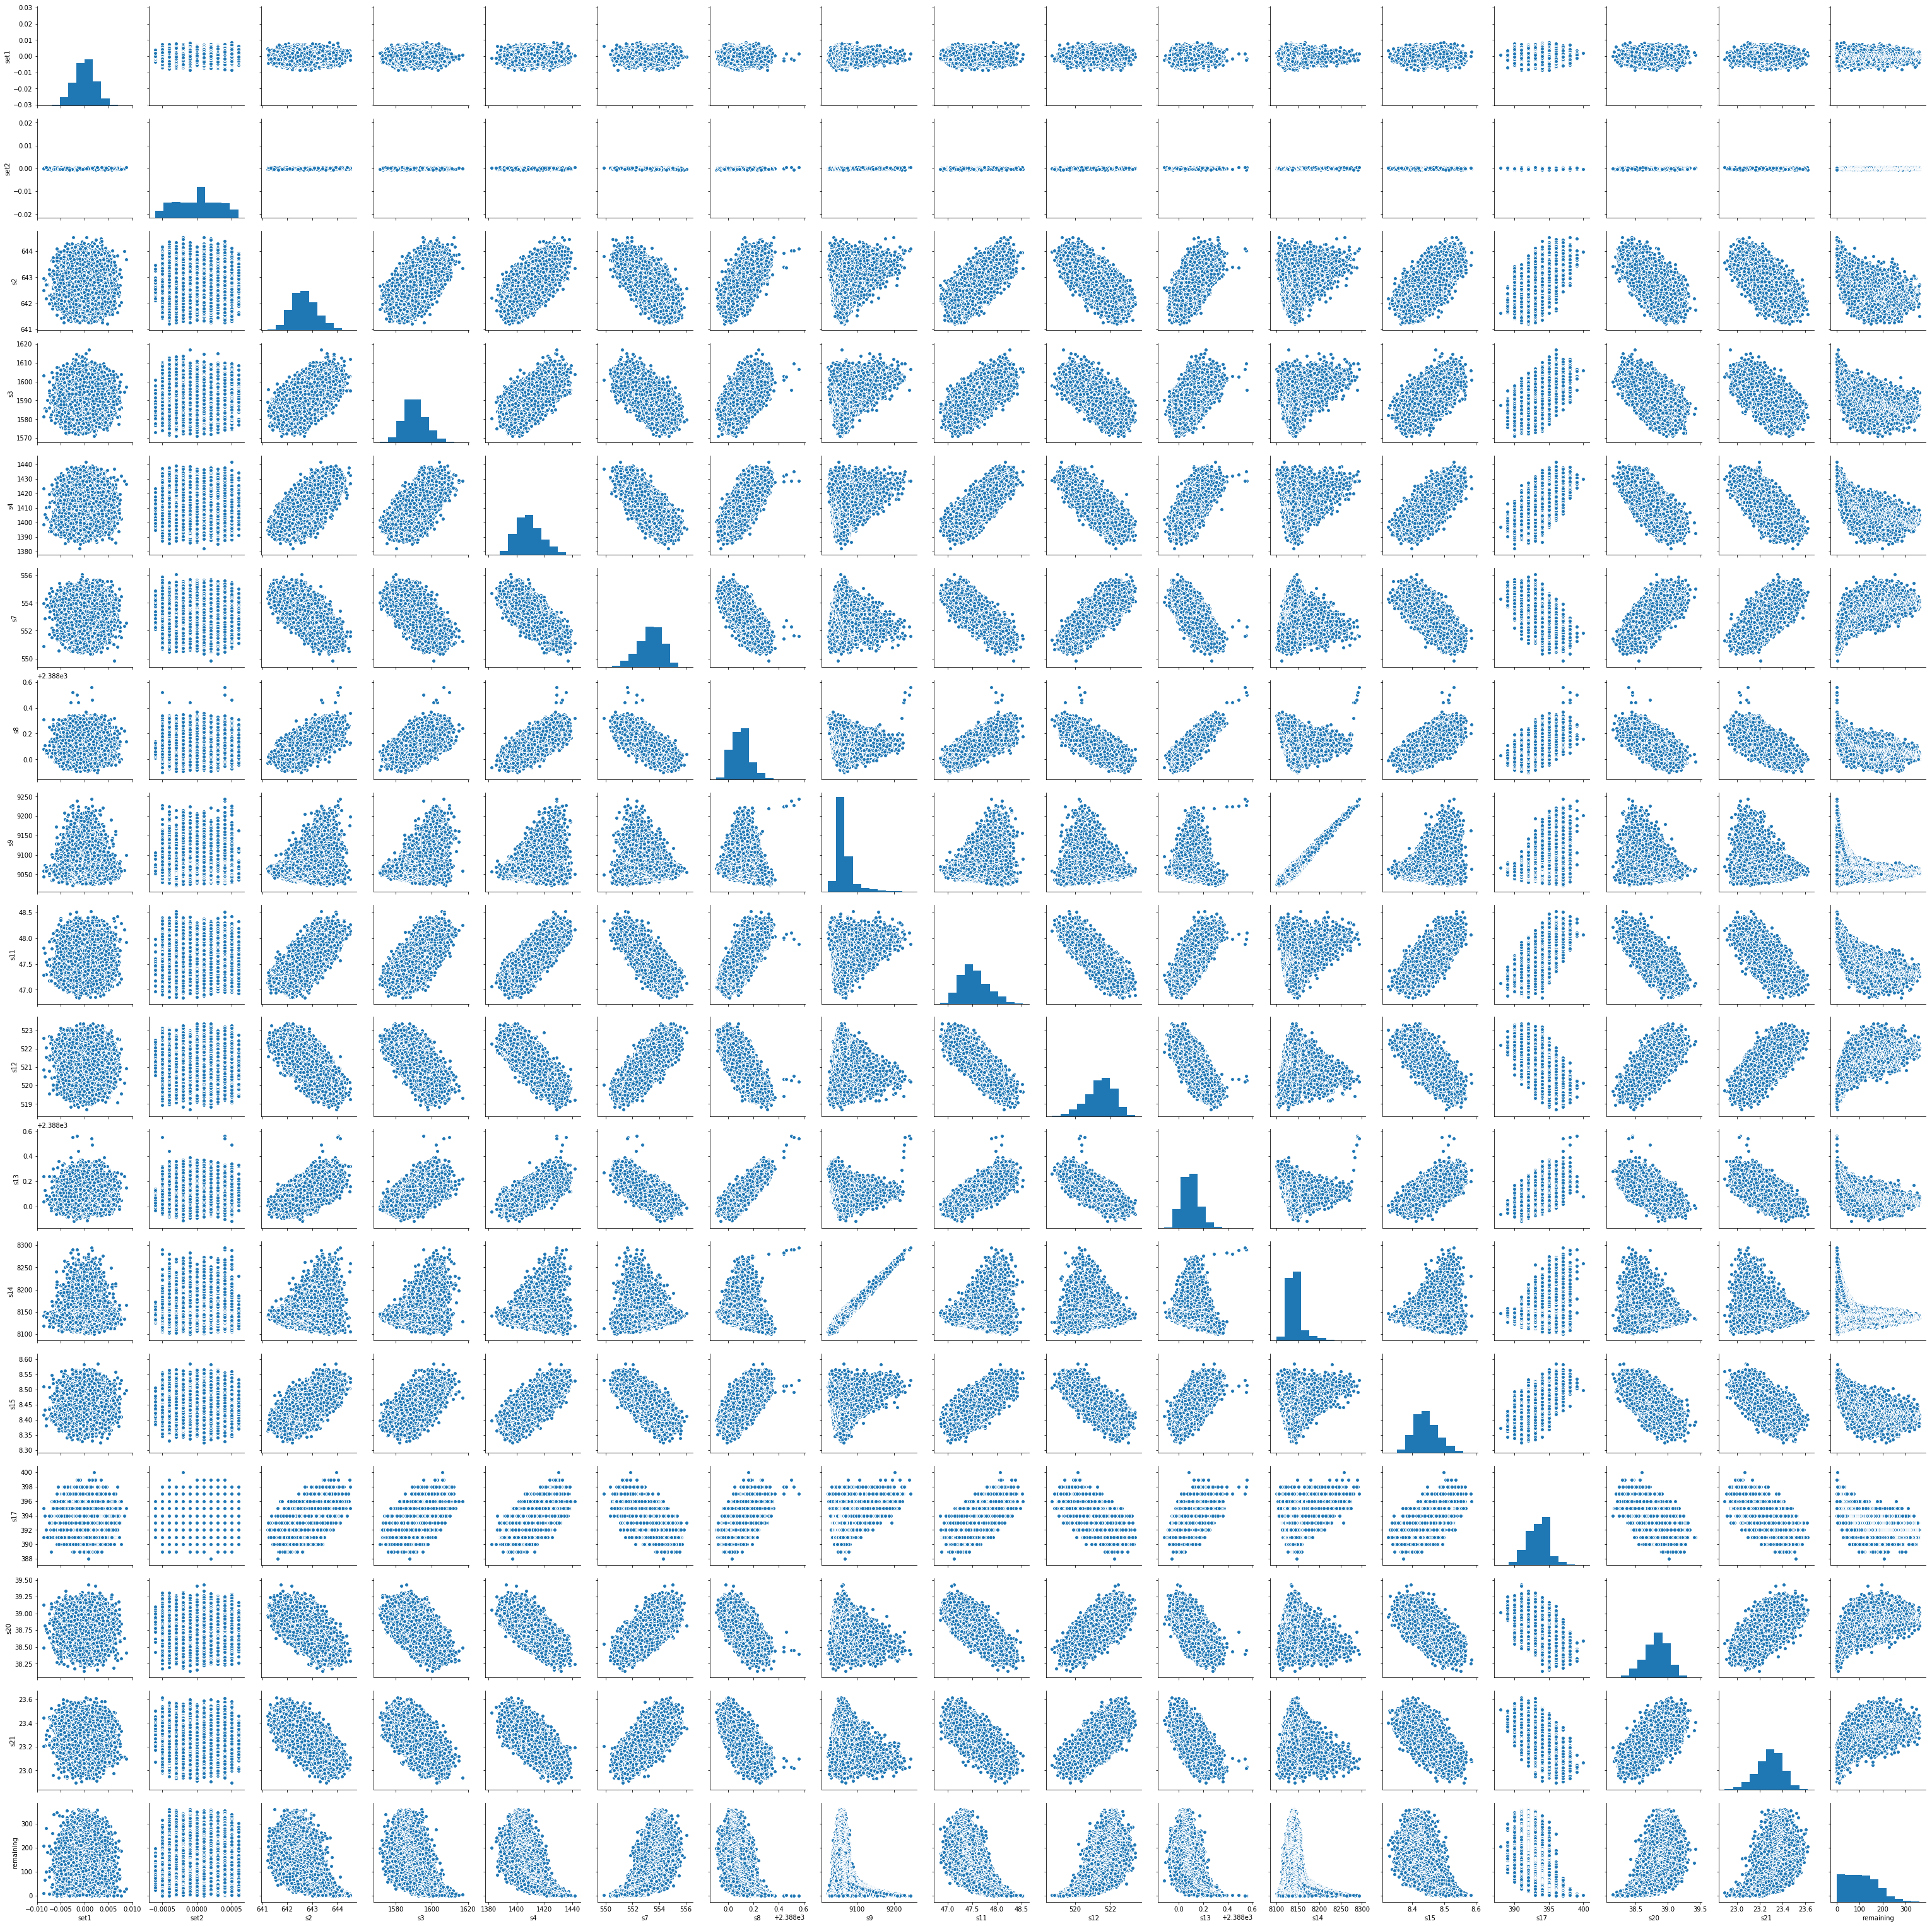

In [15]:
sns.pairplot(train_data.iloc[:,2:])

### There are multiple columns that appear to have correllations
We can look at those more closely.  
The last row(column) is the number of cycles to failure. Multiple variables seem to drift as time increases. For example the 3rd, 4th, and 5th columns (s2, s3, s4) have their highest values at the bottom, where the remaining cycles are low. Also the 6th and 10th columns (s7, s12) have their highest values at low remaining cycles. This may indicate some degredation is taking place.  
The next two rows (columns) are the settings.  There seems to be very little correllation between the settings and the sensors.
There are a number of correllations between the sensor data.
 - Rows 9(s8) and 13(s13) have a very strong correllation.
 - There are less significant correllations between S1 and many other variables.
 This may indicate PCA could be useful to simplify the model.  
 
 ## Modeling
 
 We need to get this data into a format that AWS Sagemaker can work with.  Since we are doing classification we need a predictor.  We will also need to format the data the way the model expects it.
 
 ### Deciding when to alert
 Initially we are going to start with calling less than 25 to cycles to failure an alert.  We can modify this later, and even come up with multiple levels of failure. 


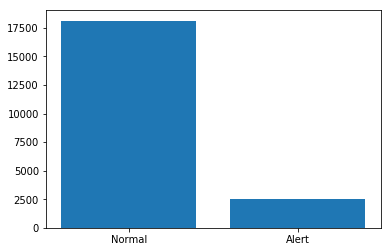

In [7]:
train_data['y'] = (train_data['remaining'] < 25 )*1  #   *1 coerces bool to int
test_data['y'] = (test_data['remaining'] < 25 )*1
plt.bar(['Normal', 'Alert'], train_data['y'].value_counts())
plt.show()

Most of the data is normal, with only a small portion of alerts.  This is known as a class imbalance.  It causes difficulty when evaluating the model, since a model that called everything "Normal" would have over 80% accuracy.  The class imbalance can be made more challenging by changing the "Alert" setting to 10 or even 5 cycles.  

We will do a train/eval split of 70/30 since there is a separate test data set available in the repo.  Note we call the 'eval' set 'valid' to avoid namespace conflicts with eval method.

In [5]:
#drop the remaining feature so we don't us it in the model.  It will predict the 'y' very well
training, valid = np.split(train_data.drop('remaining', axis = 1).sample(frac=1, random_state=1492), [int(0.7*len(train_data))])
training.shape

(14441, 26)

In [6]:
valid.shape

(6190, 26)

## k-NN Model
## Pre-Process the data
We need to arrange the data in a format that the algorithm can understand and upload to s3. AWS provides a number of packages to help format and upload the data.  The `smac` package. `sagemaker.amazon.common` provides an ML specific helper function, while the `boto3` package provides a more generic helper function for working with S3 cloud storage.  This example is based on https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/k_nearest_neighbors_covtype/k_nearest_neighbors_covtype.ipynb which is provided by AWS.  There are some changes made to it and the next model to align them.
The only feature selection done was to split the data frame into a features matrix and a label array.  Every feature, except those dropped during the exploratory phase, including the ID and cycle were used.

In [ ]:
key = 'recordio-pb-data'

train_buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(train_buf,training.iloc[:,:-1].to_numpy(),training.iloc[:,-1].to_numpy())
train_buf.seek(0)

valid_buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(valid_buf,valid.iloc[:,:-1].to_numpy(), valid.iloc[:,-1].to_numpy())
valid_buf.seek(0)

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'knn/train', key)).upload_fileobj(train_buf)
s3_train_data = 's3://{}/{}/knn/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'knn/valid', key)).upload_fileobj(valid_buf)
s3_valid_data = 's3://{}/{}/knn/valid/{}'.format(bucket, prefix, key)
print('uploaded eval data location: {}'.format(s3_valid_data))
#boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'knn/test', key)).upload_fileobj(test_buf)


### Train the k-NN Model  
One of the features of Sagemaker is that they have prebuild the models into containers with a well defined interface.  I don't need to import the classifier from SK learn.  I just get the prebuilt container from AWS, set the hyperparameters and provide it an output path for the model. When getting the container you specify the type of compute. That allows you to run the notebook on a relatively small/cheap server, while the traiing the model on a larger one.  It also allows for selecting a VM with GPUs to train a deep learning model on.
Once you have the handle for the container you just have to call fit with the path to the data on it.  At that point AWS will deploy the container, run the training, save the model and stop the compute.  You only pay for the comput you used.  As shown in the log the final model used `107` seconds of compute. 

In [28]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'knn')
hyperparameters = {'k':7,
                   'predictor_type':'classifier',
                   'sample_size':14441,
                  'feature_dim':18}

# set up the estimator
knn = sagemaker.estimator.Estimator(container,
    role,
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    output_path='s3://{}/{}/knn/output'.format(bucket, prefix),
    sagemaker_session=session)
knn.set_hyperparameters(**hyperparameters)

# train a model. fit_input contains the locations of the train and test data
fit_input = {'train': s3_train_data}
fit_input['test'] = s3_valid_data
knn.fit(fit_input)

2020-04-09 12:49:59 Starting - Starting the training job...
2020-04-09 12:50:00 Starting - Launching requested ML instances......
2020-04-09 12:51:04 Starting - Preparing the instances for training...
2020-04-09 12:51:42 Downloading - Downloading input data...
2020-04-09 12:52:04 Training - Downloading the training image......
2020-04-09 12:53:29 Uploading - Uploading generated training model
2020-04-09 12:53:29 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/09/2020 12:53:19 INFO 140400032212800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u

In [29]:
#Capture the training job name so don't have to retrain every time we open the notebook.
knn._current_job_name

'knn-2020-04-09-12-49-59-137'

From the model log we can capture the test scoring of accuracy and F1.
### Tune the model
There are two hyperparameters for k-NN.
- k the number of nearest neighbors.  This is the classic bias/variance tradaeoff.  Small k provides a very flexible boundry, large k provides a smoother one.
- sample_size the numberof instances used, this primarily impacts the training time. 

This is an example of manual hyperparameter tuning, since there is only one parameter and the model runs quickly we can tune it manually in a short amount of time.  For other models with more hyperparameters, or if this model had significantly more data and had a training time on the order of hours, AWS provides an API to autotune the hyperparameters.

https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html

| k | N | accuracy | Macro_F1 | Binary_F1 | time | note|
|-|-|-|-|-|-|-|
|15| 14441| .973 | .934 | .884 | 64 ||
|10| 14441 |.974| .936| .888 | 50 ||
| 5 | 14441 | .974 | .938 | .892 | 56 ||
| 3 | 14441 | .973 | .937 | .890 | 51 ||
| 5 | 7220 | .967 | .921 | .861| 53 ||
|10| 7220 |.959 | .893 | .810 | 59 ||
| 7 | 14441 | .977 | .945 |.903 | 58 ||
|8| 14441 | .973 | .956 |.886 | 93 ||
| 7 | 14441 | .977 | .945 | .903 | 107 |  Model used going forward |

It appears that we do not have enough data to notice impact the of sample_size on training time, but it does impact accuray.  These samples were run in the early AM, and it appears that the last couble of samples took longer to run.  Possibly indicating increased demand on AWS compute and network resources.  
Rerun the 7/14441 model one more time and enter the job name below. This will prevent the need to retrain when coming back to the notebook.  You can pick up and use the model at any time.

#### Set up Endpoint
AWS deploys the model to an endpoint and then does inference from that.  This allows you to use a smaller instance for doing inference than it took to train the model.  Becuase it's deployed to an endpoint this model is now ready to be consumed by an application.

note: That they replicate the log from when it was trained when deploying  This allows you to see the accuracy and confirm it's the correct model.



In [31]:
#load the model
knn_saved = sagemaker.estimator.Estimator.attach('knn-2020-04-09-12-49-59-137')

from sagemaker.predictor import csv_serializer, json_deserializer

knn_predictor = knn_saved.deploy( initial_instance_count=1, 
                           instance_type= 'ml.m4.xlarge',
                          endpoint_name='knn-ml-m4-xlarge%s'%(str(time.time()).replace('.','-')))
knn_predictor.content_type = 'text/csv'
knn_predictor.serializer = csv_serializer
knn_predictor.deserializer = json_deserializer


2020-04-09 12:53:29 Starting - Preparing the instances for training
2020-04-09 12:53:29 Downloading - Downloading input data
2020-04-09 12:53:29 Training - Training image download completed. Training in progress.
2020-04-09 12:53:29 Uploading - Uploading generated training model
2020-04-09 12:53:29 Completed - Training job completedDocker entrypoint called with argument(s): train
Running default environment configuration script
[04/09/2020 12:53:19 INFO 140400032212800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[04/09/2020 12:53:19 INFO 140400032212800] Reading provided configuration from /opt/ml/input/config/hyperpara

Using already existing model: knn-2020-04-09-12-49-59-137


-------------------------!

#### Inference
Inference is the process of using a trainined model to get predictions on new data.  This evaluation with unseen data provides an unbiaased look at the model performance on new data. Becuase we did not use as much compute for the model, we break the test data into pieces for the training and provide it to the model piecmeal for inference and then combine the results.  This could be generalized to horizontally scaled the inference across multiple endpoints to do a large inference job in parallel.  That's not required for this job which completeed in a matter of seconds.  

After completing inference we delete the model to avoid being charged for the compute time.


In [33]:
batches = np.array_split(test_data.iloc[:,:-2].to_numpy(), 100)
print('data split into 100 batches, of size %d.' % batches[0].shape[0])

# obtain an np array with the predictions for the entire test set
start_time = time.time()
predictions = []
for batch in batches:
    result = knn_predictor.predict(batch)
    cur_predictions = np.array([result['predictions'][i]['predicted_label'] for i in range(len(result['predictions']))])
    predictions.append(cur_predictions)
predictions = np.concatenate(predictions)
run_time = time.time() - start_time


data split into 100 batches, of size 131.


In [46]:
test_labels = test_data.iloc[:,-1].to_numpy() 
test_size = test_labels.shape[0]
results = pd.crosstab(index=test_labels, columns=predictions)
true_positives = results.iloc[1,1]
false_positives = results.iloc[0,1]
false_negatives = results.iloc[1,0]
true_negatives = results.iloc[0,0]

print('time required for predicting %d data point: %.2f seconds' % (test_size, run_time))
print('True positives are %d, false positives are %d and false negatives are %d ' % (true_positives, false_positives, false_negatives) )
print('Accuracy : %.1f%%' % ((true_positives +true_negatives)/float(test_size)*100))
print('Precision : %.1f%%' % (float(true_positives)/(true_positives+false_positives)*100))
print('Recall : %.1f%%' % (float(true_positives)/(true_positives+false_negatives)*100))

print("\n\nConfusion Matrix")
print(results)

time required for predicting 13096 data point: 2.56 seconds
True positives are 122, false positives are 135 and false negatives are 77 
Accuracy : 98.4%
Precision : 47.5%
Recall : 61.3%


Confusion Matrix
col_0    0.0  1.0
row_0            
0      12762  135
1         77  122


In [37]:
#Delete endpoint
try:
    boto3.client('sagemaker').delete_endpoint(EndpointName=knn_predictor.endpoint)
    print('Deleted {}'.format(knn_predictor.endpoint))
except:
    print('Already deleted: {}'.format(knn_predictor.endpoint))



Deleted knn-ml-m4-xlarge1586438274-5443077


The results from the indicate one of the risks of prognostics.  The test set was even more unbalanced than the training set so the accuracy went up slightly even while the F1 decreased to 0.27. This is because there are now only 199 positive test cases in 13096 data points.  

### XGBoost Model  
Boosted models perform better when there is a class imbalance.  One popular boosted model is the open-source XGBoost https://xgboost.readthedocs.io/en/latest/. XGBoost is a gradient boosted parallel random forest. It iteratively improves on a weak classifier to minimize the loss function.  
Because the data set has not changed we do not need to repeat the exploritory analysis,  but we do need to reformat the data. The XGBoost Model expects the labels to be coded in separate columns.  This is known as 1-hot encoding, we are using it here for binary classification, but it could easily be extended to a multiclass classifier.  The table below shows the a sample of the changes. The original column was a boolean 1/0, which is converter to text 'yes'/'no' and then 1-hot encoded.

| Original Columns | First Conversion | Second |Conversion |
|------------------|------------------|-------------------|-|
| y                |        y         |  y_yes   | y_no     |
| 1                |        yes       |    1     |  0       |
| 0                |        no        |    0     |   1      |


This example is based on the AWS video game rating example at:
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/video_game_sales/video-game-sales-xgboost.ipynb
 

In [24]:
#one-hot encode
if training['y'].dtype == 'int64':
    training['y'] = training['y'].apply(lambda y: 'yes' if y == 1 else 'no')
train_input = pd.get_dummies(training)
if valid['y'].dtype == 'int64':
    valid['y'] = valid['y'].apply(lambda y: 'yes' if y == 1 else 'no')
valid_input = pd.get_dummies(valid)
if test_data['y'].dtype == 'int64':
    test_data['y'] = test_data['y'].apply(lambda y: 'yes' if y == 1 else 'no')
test_input = pd.get_dummies(test_data)

In [25]:
test_input.head()

id  cycle    set1    set2      s2       s3       s4      s7       s8  \
0   1      1  0.0023  0.0003  643.02  1585.29  1398.21  553.90  2388.04   
1   1      2 -0.0027 -0.0003  641.71  1588.45  1395.42  554.85  2388.01   
2   1      3  0.0003  0.0001  642.46  1586.94  1401.34  554.11  2388.05   
3   1      4  0.0042  0.0000  642.44  1584.12  1406.42  554.07  2388.03   
4   1      5  0.0014  0.0000  642.51  1587.19  1401.92  554.16  2388.01   

        s9  ...     s12      s13      s14     s15  s17    s20      s21  \
0  9050.17  ...  521.72  2388.03  8125.55  8.4052  392  38.86  23.3735   
1  9054.42  ...  522.16  2388.06  8139.62  8.3803  393  39.02  23.3916   
2  9056.96  ...  521.97  2388.03  8130.10  8.4441  393  39.08  23.4166   
3  9045.29  ...  521.38  2388.05  8132.90  8.3917  391  39.00  23.3737   
4  9044.55  ...  522.15  2388.03  8129.54  8.4031  390  38.99  23.4130   

   remaining  y_no  y_yes  
0        142     1      0  
1        141     1      0  
2        140     1      0  
3        139     1      0  
4        138     1      0  

[5 rows x 21 columns]

#### Save the data
The model also expects the data encoded as a .libsvm file instead of a .csv which the kNN used.  Annother thing to note here is that while Pandas.get_dummies() split the 'y' column into 'y_yes' and 'y_no', we only use the'y_yes' column.  This intuitively makes sense because theprediction of no is just the inverse of predicting both, and there is no reason to predict both. 

In [28]:

dump_svmlight_file(X=train_input.drop(['y_no', 'y_yes'], axis=1), y=train_input['y_yes'], f='train.libsvm')
dump_svmlight_file(X=valid_input.drop(['y_no', 'y_yes'], axis=1), y=valid_input['y_yes'], f='valid.libsvm')
#drop remaining, already removed from training set
dump_svmlight_file(X=test_input.drop(['remaining','y_no', 'y_yes'], axis=1), y=test_input['y_yes'], f='test.libsvm')

s3.Bucket(bucket).Object(prefix + '/xgb/train/train.libsvm').upload_file('train.libsvm')
s3.Bucket(bucket).Object(prefix + '/xgb/valid/valid.libsvm').upload_file('valid.libsvm')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/xgb/train'.format(bucket, prefix), content_type='libsvm')
s3_input_valid = sagemaker.s3_input(s3_data='s3://{}/{}/xgb/valid/'.format(bucket, prefix), content_type='libsvm')

#### Train the classifier
The remaining steps of getting a container, calling a classifier, and deploying it to an endpoint for inference are similar. There are additional parameters to consider. Becuase XGBoost isparallelized algorithm, there is the option to select multiple VM instances to train it on.  For this example we only select one.
There are also multiple hyperparameters to select from, the details are here: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

In [29]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost','0.90-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='AircraftEngines-xgboost',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/xgb/output'.format(bucket, prefix),
                                    sagemaker_session=session)


In [30]:

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=2.0,
                        num_round=100)
xgb.fit({'train': s3_input_train, 'validation': s3_input_valid})

2020-04-09 18:38:05 Starting - Starting the training job...
2020-04-09 18:38:07 Starting - Launching requested ML instances......
2020-04-09 18:39:11 Starting - Preparing the instances for training...
2020-04-09 18:39:54 Downloading - Downloading input data...
2020-04-09 18:40:35 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[18:40:37] 14441x18 matrix with 258238 entries loaded from /opt/ml/input/data/train
[18:40:37] 6190x18 matrix with 110637 entries loaded from /opt/ml/input/data/validatio

#### Model Evaluation
The container for the XGBoost allows more operations for evaluation than just classification/regression. I chose AUC (Area Under the Curve) as it is more sensitive than the accuracy that is the only choice for kNN.  AUC is also known as ROC (Receiver Operating Characteristic).

Again we capture the name to allow doing prediction w/o retraining the model.  The models are also available through the Sagemaker UI.

In [34]:
xgb._current_job_name

'DEMO-videogames-xgboost-2020-04-09-18-38-05-774'

### Test  
#### Deploy the model
First we need to deploy the model to an endpoint.

In [31]:
#load the model
xgb_saved = sagemaker.estimator.Estimator.attach('DEMO-videogames-xgboost-2020-04-09-18-38-05-774')

xgb_predictor = xgb_saved.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

-------------!

In [32]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [36]:
%%time


with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)


...................................................................................................................................CPU times: user 485 ms, sys: 15.2 ms, total: 500 ms
Wall time: 2.31 s


In [39]:
results = pd.crosstab(index=np.array(labels), columns=np.array(preds))

true_positives = results.iloc[1,1]
false_positives = results.iloc[0,1]
false_negatives = results.iloc[1,0]
true_negatives = results.iloc[0,0]
test_size = len(preds)

print('True positives are %d, false positives are %d and false negatives are %d ' % (true_positives, false_positives, false_negatives) )
print('Accuracy : %.1f%%' % ((true_positives +true_negatives)/float(test_size)*100))
print('Precision : %.1f%%' % (float(true_positives)/(true_positives+false_positives)*100))
print('Recall : %.1f%%' % (float(true_positives)/(true_positives+false_negatives)*100))

print("\n\nConfusion Matrix")
print(results)


True positives are 153, false positives are 74 and false negatives are 46 
Accuracy : 99.1%
Precision : 67.4%
Recall : 76.9%


Confusion Matrix
col_0      0    1
row_0            
0      12823   74
1         46  153


#### Results
We can see the improved results clearly in the precision and accuracy, two thirds of the predicted failures are actually failures, vs less than half before. That is way more dramatic than the change in accuracy from 98.4% to 99.1%.   

### Cleanup
If you are finished with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.




In [24]:
session.delete_endpoint(xgb_predictor.endpoint)

## Conclusion
During this report I demonstrated the use of two different classification algorithms using the models available from AWS. The two classifiers we looked at needed different preprocessing even on this relatively clean data set, both in how the labels were encoded and in the save format for the data file. The first model kNN is provided seemingly very good results, at 98.4% accuracy, but when you look closer at the confusion matrix you can see that it's predictions of a failure were correct less than half the time.  The sceond model we looked at was a binary classifier using the XGBoost algorithm.  It selected it had much better performance on the positive class, which translated into a small improvement in accuracy.  
This report only touched the surface of the tools available at AWS Sagemaker for classification. The XGBoost algorithm could also be used as multi-classifier.  We could select Alert at <25 cycles, and Critical at <5 cycles to failure.  We could also do a classification based regression where we bin the labels `[0-10), [10-20), [20-30), etc.` and do a classification based pseudo regression.
AWS Sagemaker also has a large number of other algoritms in machine learning.  They are all implemented using a similar pattern of formatting and saving the data to S3, getting a container and calling fit() on the container.  They then allow you to deploy your model to an endpoint for use.


This document is stored at https://github.com/Gamecock/AircraftEngines and may be updated in the future with additional examples.